Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB
None

Missing Values:
 Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_C

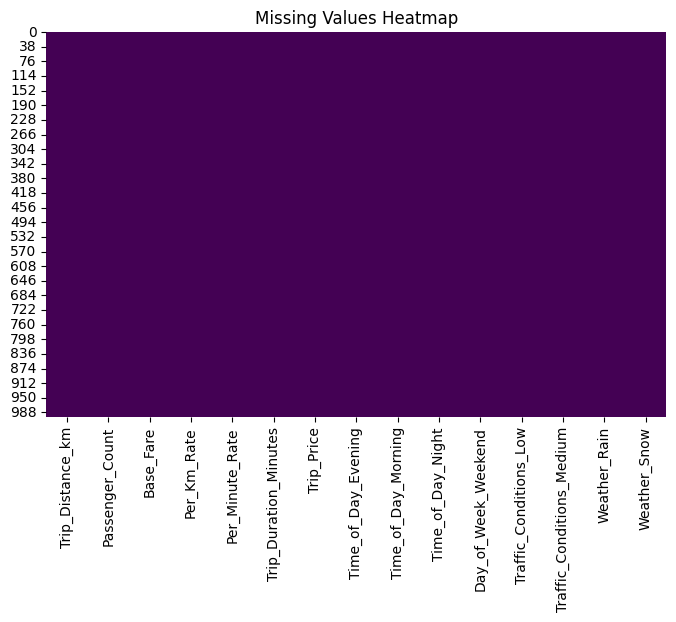

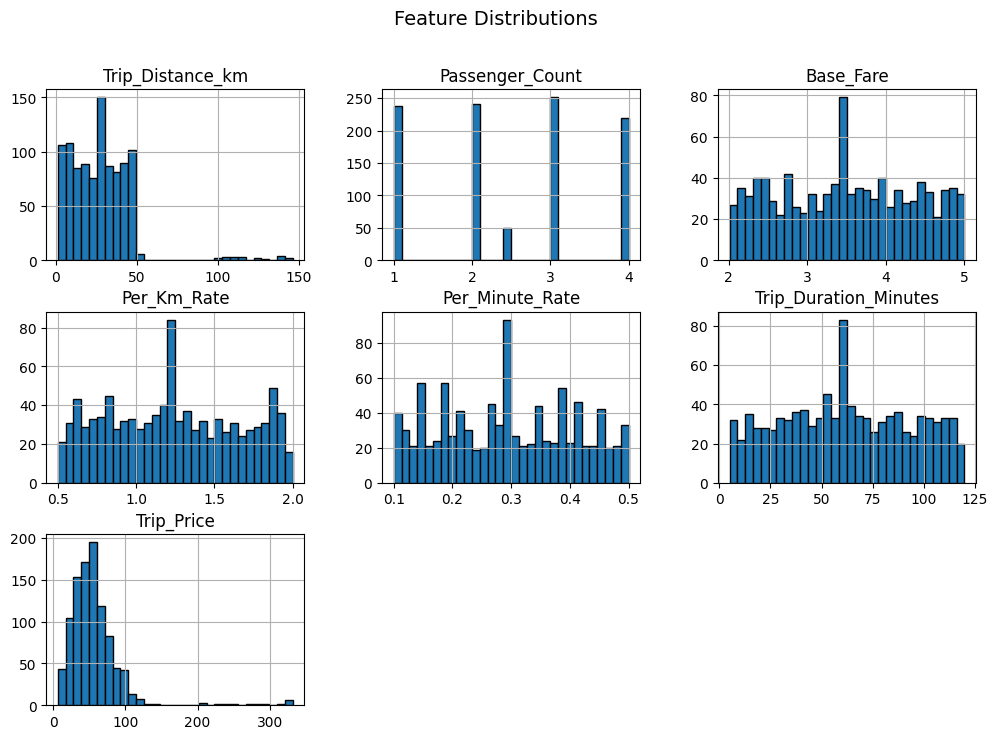

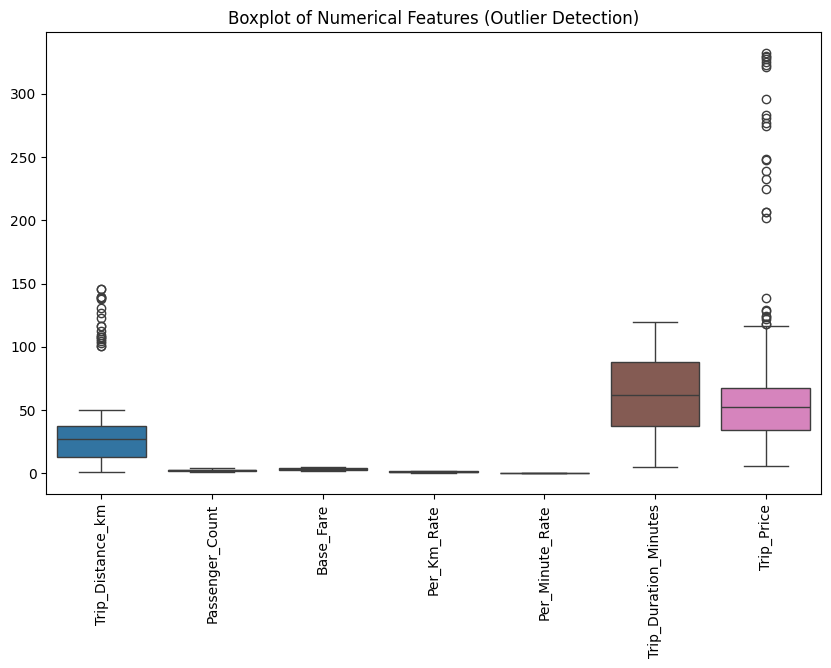

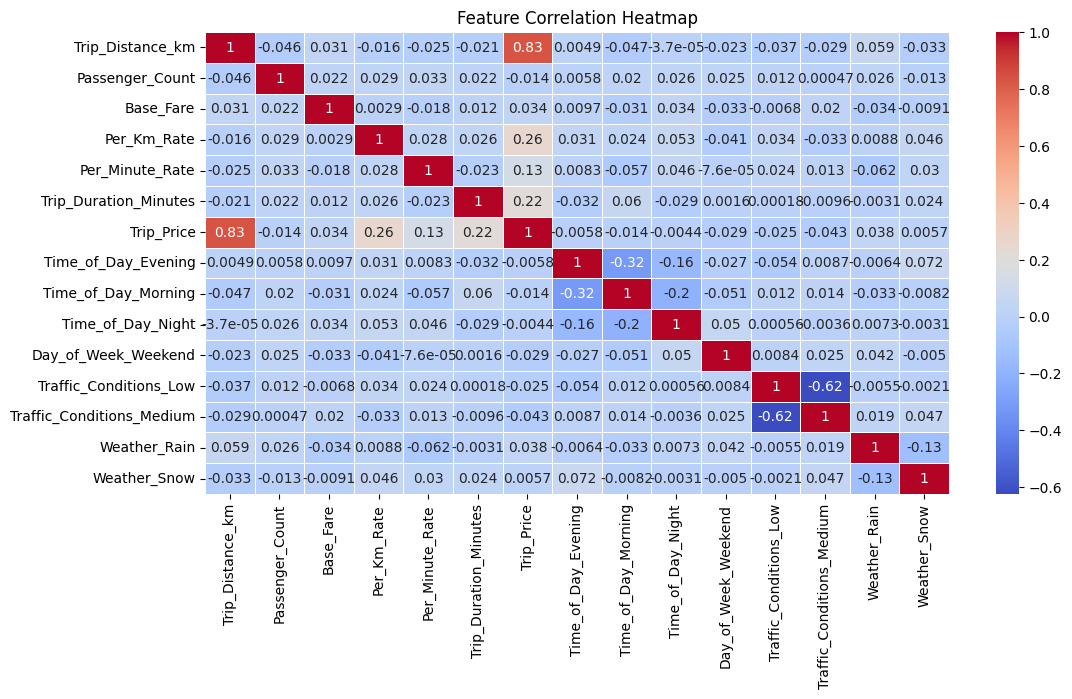

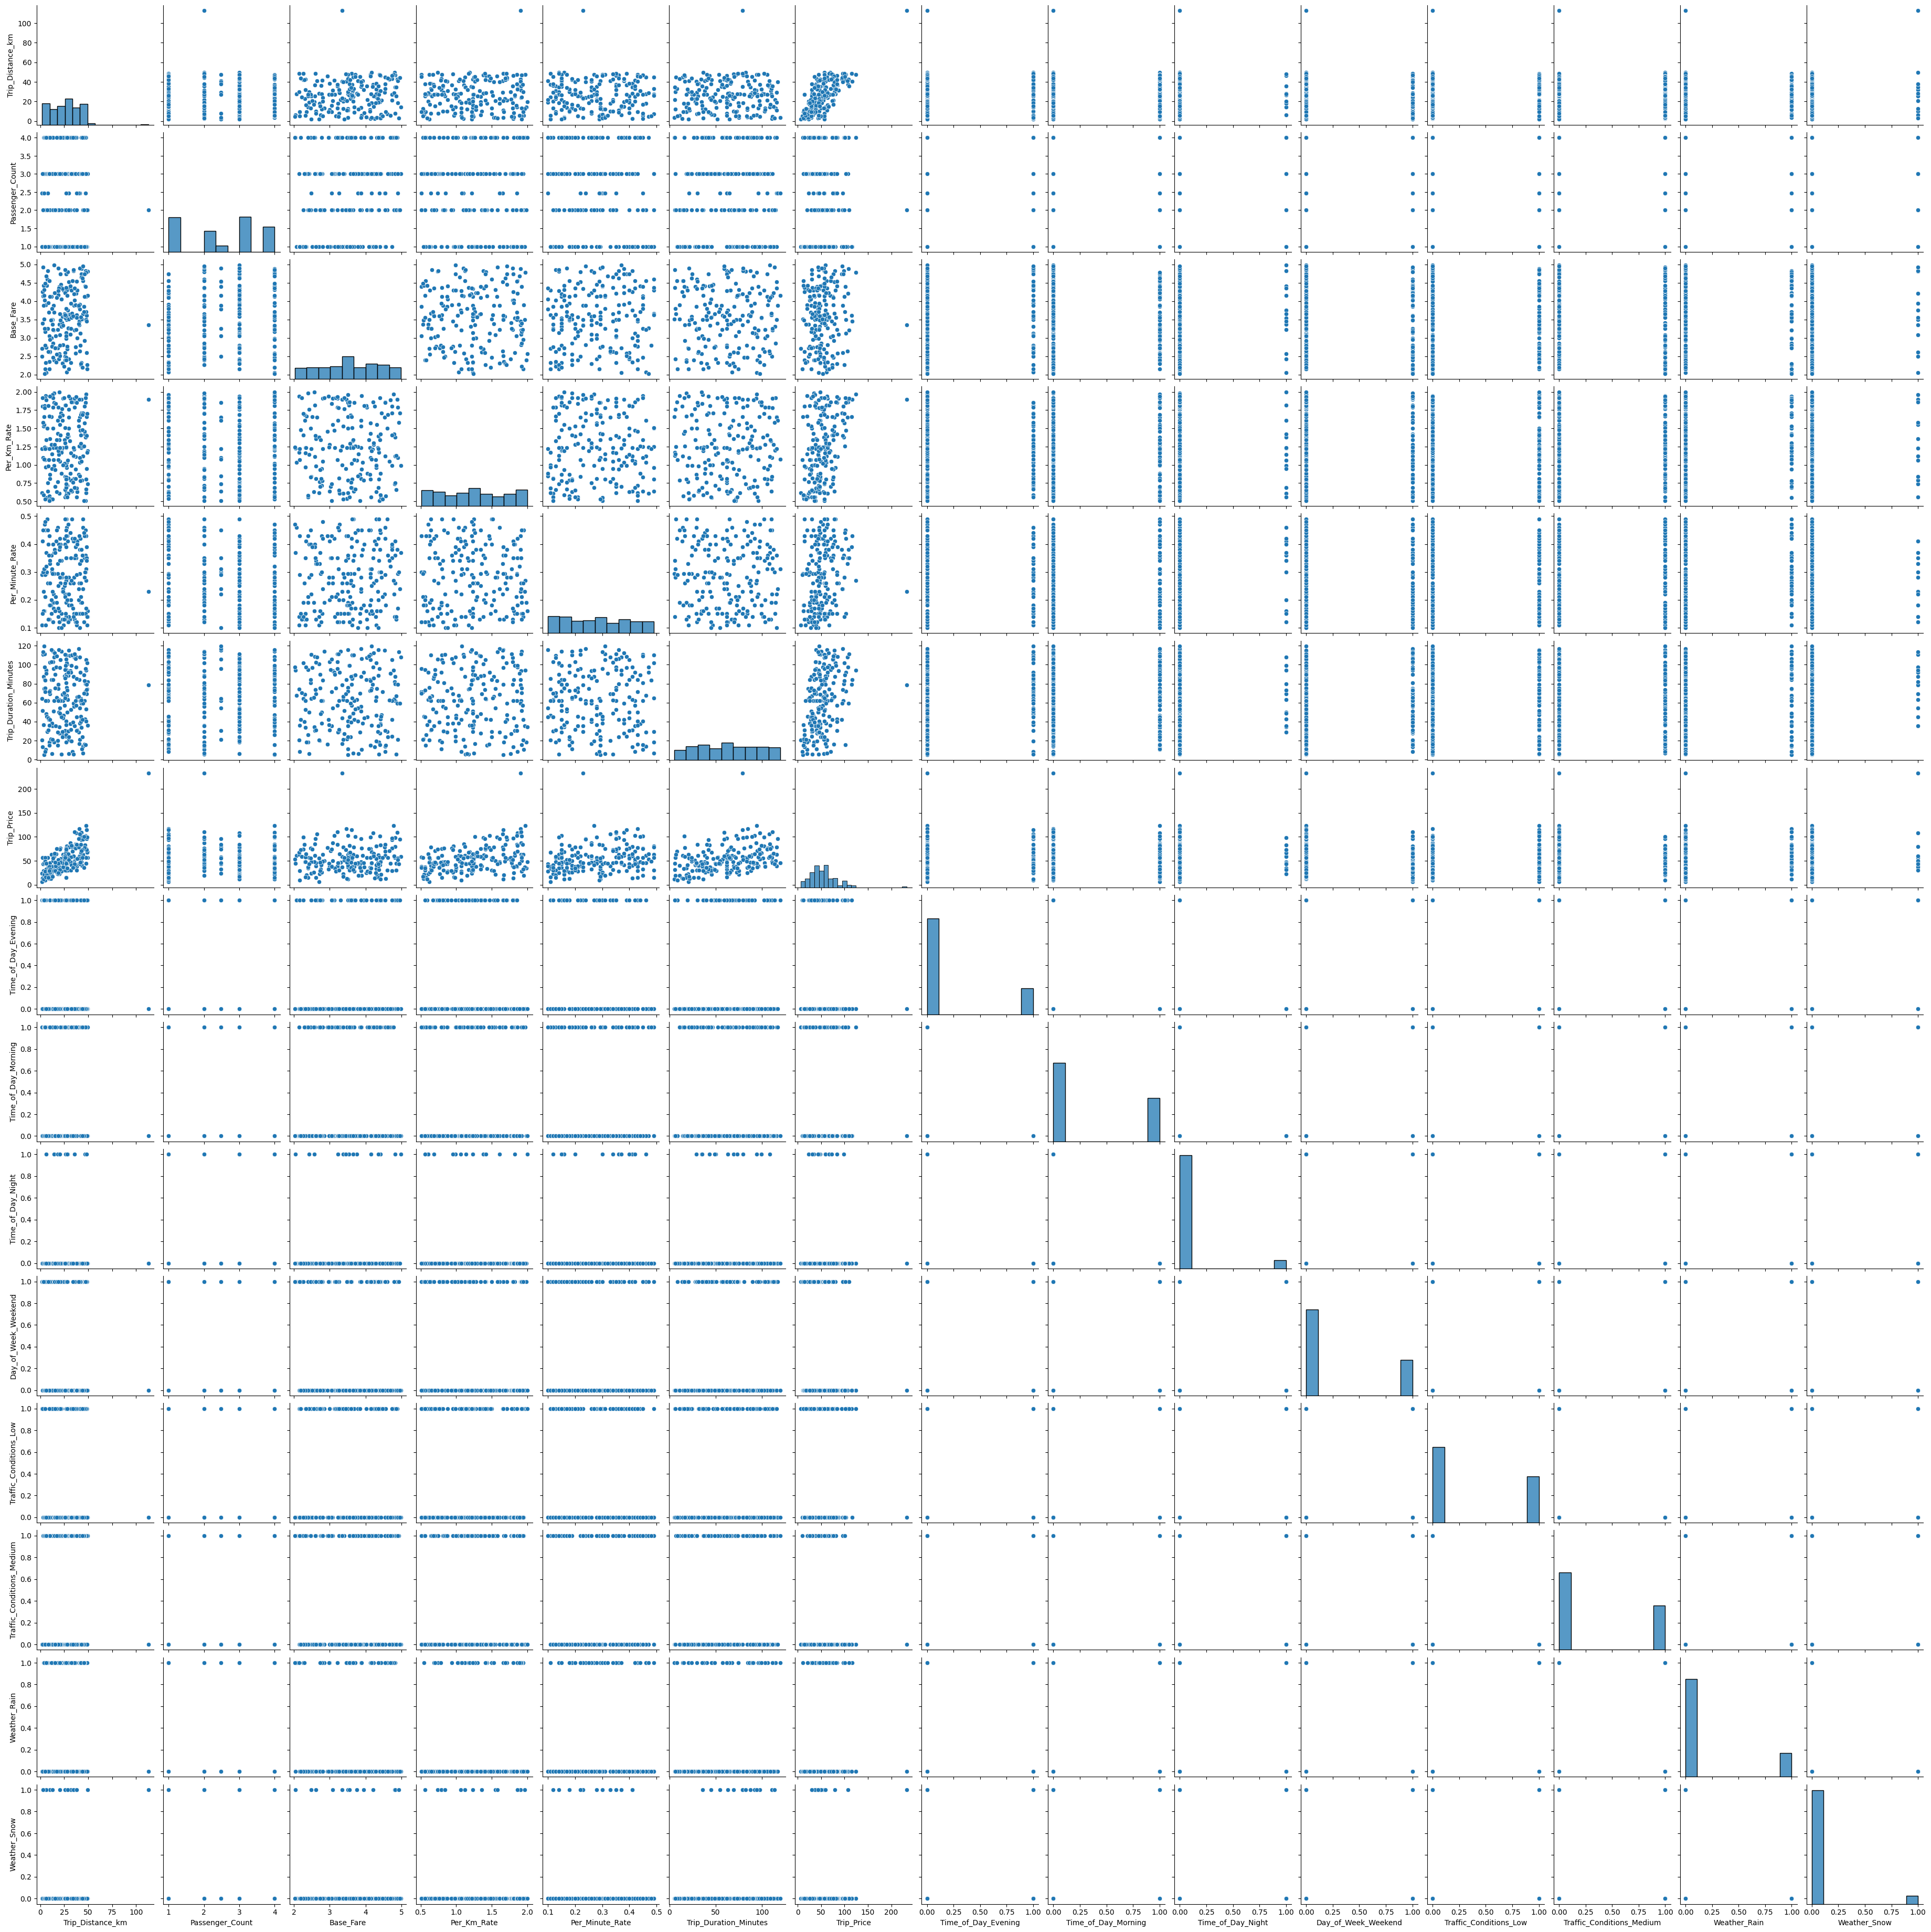

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Concepts and Technologies of AI./taxi_trip_pricing.csv')

# Inspect dataset structure
print("Dataset Information:")
print(df.info())
print("\nMissing Values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())

# Handling missing values
numeric_cols = df.select_dtypes(include=['number']).columns  # Selecting only numeric columns
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].mean())  # Fill missing numeric values with mean

# Convert categorical variables to numerical
categorical_cols = ['Time_of_Day', 'Day_of_Week', 'Traffic_Conditions', 'Weather']
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Updated summary statistics after cleaning
print("\nUpdated Summary Statistics:\n", df.describe())

# Visualizing missing values (if any)
plt.figure(figsize=(8, 5))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False)
plt.title("Missing Values Heatmap")
plt.show()

# Histogram of numerical features
df.hist(figsize=(12, 8), bins=30, edgecolor='black')
plt.suptitle("Feature Distributions", fontsize=14)
plt.show()

# Boxplots to identify outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[numeric_cols])
plt.xticks(rotation=90)
plt.title("Boxplot of Numerical Features (Outlier Detection)")
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(12, 6))
corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

# Pairplot for relationship exploration
sns.pairplot(df.sample(200))  # Sampling to prevent performance issues
plt.show()


Model Performance Comparison:
Linear Regression - MAE: 9.8352, RMSE: 13.9249, R-squared: 0.7665
Random Forest - MAE: 5.5891, RMSE: 7.9449, R-squared: 0.9240

Best Model: Random Forest


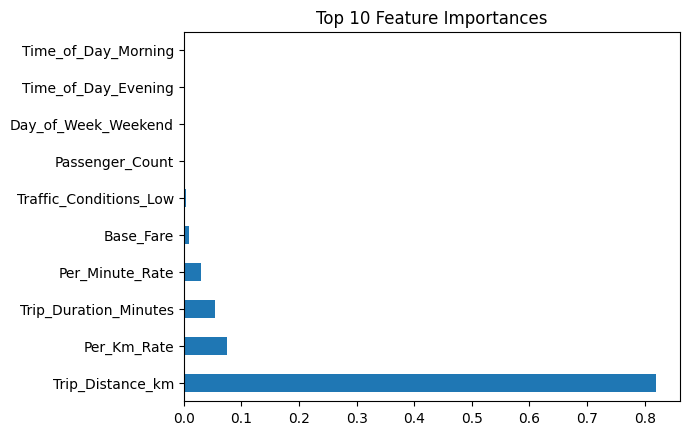

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# Define features and target
X = df.drop('Trip_Price', axis=1)
y = df['Trip_Price']

# Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# Random Forest Model with Hyperparameter Tuning
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluation function
def evaluate_model(name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    # Calculate RMSE without the 'squared' argument
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f'{name} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')
    return mae, rmse, r2

# Evaluate both models
print("Model Performance Comparison:")
lr_metrics = evaluate_model("Linear Regression", y_test, y_pred_lr)
rf_metrics = evaluate_model("Random Forest", y_test, y_pred_rf)

# Final Decision
best_model = "Random Forest" if rf_metrics[1] < lr_metrics[1] else "Linear Regression"
print(f"\nBest Model: {best_model}")

# Feature Importance (for Random Forest)
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(rf_model.feature_importances_, index=df.drop('Trip_Price', axis=1).columns)
feature_importances.nlargest(10).plot(kind='barh', title="Top 10 Feature Importances")
plt.show()


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

# ---- Hyperparameter Tuning for Random Forest ----
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                              param_grid=rf_param_grid, cv=5, scoring='r2', n_jobs=-1)
rf_grid_search.fit(X_train, y_train)

# Best parameters for Random Forest
print("Best Random Forest Parameters:", rf_grid_search.best_params_)

# ---- Hyperparameter Tuning for Ridge Regression ----
ridge_param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

ridge_grid_search = GridSearchCV(estimator=Ridge(),
                                 param_grid=ridge_param_grid, cv=5, scoring='r2', n_jobs=-1)
ridge_grid_search.fit(X_train, y_train)

# Best parameters for Ridge Regression
print("Best Ridge Regression Parameters:", ridge_grid_search.best_params_)


Best Random Forest Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best Ridge Regression Parameters: {'alpha': 10}


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# ---- Method 1: Feature Importance from Random Forest ----
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

importances = rf_model.feature_importances_
feature_importances = pd.Series(importances, index=X.columns)
feature_importances.sort_values(ascending=False, inplace=True)

# Select top 5 features
top_features_rf = feature_importances.index[:5]
print("Top 5 Features (Random Forest):\n", top_features_rf)

# ---- Method 2: Recursive Feature Elimination (RFE) ----
lin_reg = LinearRegression()
rfe = RFE(lin_reg, n_features_to_select=5)  # Selecting 5 best features
rfe.fit(X_train, y_train)

# Get selected features
# Use X.columns instead of X_train.columns to get feature names
top_features_rfe = X.columns[rfe.support_]
print("Top 5 Features (RFE):\n", top_features_rfe)

# ---- Train models using selected features ----
X_train_selected = X_train[:, rfe.support_] # Using RFE-selected features
X_test_selected = X_test[:, rfe.support_]

# Train new Random Forest model
rf_model_selected = RandomForestRegressor(random_state=42)
rf_model_selected.fit(X_train_selected, y_train)

# Predictions & Evaluation
y_pred_selected = rf_model_selected.predict(X_test_selected)
r2_selected = r2_score(y_test, y_pred_selected)
print(f"R-squared with Selected Features: {r2_selected}")

Top 5 Features (Random Forest):
 Index(['Trip_Distance_km', 'Per_Km_Rate', 'Trip_Duration_Minutes',
       'Per_Minute_Rate', 'Base_Fare'],
      dtype='object')
Top 5 Features (RFE):
 Index(['Trip_Distance_km', 'Per_Km_Rate', 'Per_Minute_Rate',
       'Trip_Duration_Minutes', 'Time_of_Day_Night'],
      dtype='object')
R-squared with Selected Features: 0.9267585937129617


In [ ]:
# Rebuild Random Forest
rf_model_final = RandomForestRegressor(**rf_grid_search.best_params_, random_state=42)
rf_model_final.fit(X_train_selected, y_train)
y_pred_rf_final = rf_model_final.predict(X_test_selected)

# Evaluation for Random Forest
mae_rf_final = mean_absolute_error(y_test, y_pred_rf_final)
# Calculate RMSE by taking the square root of MSE
rmse_rf_final = np.sqrt(mean_squared_error(y_test, y_pred_rf_final))
r2_rf_final = r2_score(y_test, y_pred_rf_final)
print(f'Final Random Forest - MAE: {mae_rf_final}, RMSE: {rmse_rf_final}, R-squared: {r2_rf_final}')

# Rebuild Linear Regression
lr_model_final = LinearRegression()
lr_model_final.fit(X_train_selected, y_train)
y_pred_lr_final = lr_model_final.predict(X_test_selected)

# Evaluation for Linear Regression
mae_lr_final = mean_absolute_error(y_test, y_pred_lr_final)
# Calculate RMSE by taking the square root of MSE
rmse_lr_final = np.sqrt(mean_squared_error(y_test, y_pred_lr_final))
r2_lr_final = r2_score(y_test, y_pred_lr_final)
print(f'Final Linear Regression - MAE: {mae_lr_final}, RMSE: {rmse_lr_final}, R-squared: {r2_lr_final}')

Final Random Forest - MAE: 5.279756757545817, RMSE: 7.738025395397237, R-squared: 0.9278906188841446
Final Linear Regression - MAE: 9.972055783908225, RMSE: 13.895576980972367, R-squared: 0.7674669779152525
